# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Load--Autoencoder" data-toc-modified-id="Load--Autoencoder-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load  Autoencoder</a></div><div class="lev1 toc-item"><a href="#K-means-clustering" data-toc-modified-id="K-means-clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>K-means clustering</a></div><div class="lev2 toc-item"><a href="#ALL" data-toc-modified-id="ALL-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>ALL</a></div><div class="lev2 toc-item"><a href="#Causal" data-toc-modified-id="Causal-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Causal</a></div><div class="lev2 toc-item"><a href="#Visualizing-Document-Clusters" data-toc-modified-id="Visualizing-Document-Clusters-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Visualizing Document Clusters</a></div><div class="lev1 toc-item"><a href="#LDA" data-toc-modified-id="LDA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>LDA</a></div>

# Load Data

In [252]:
import json
import os

In [253]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [254]:
sentence = load_data('all_data.json', 'sentence')
label = load_data('all_data.json', 'label')

# Word Segmentation

In [255]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [256]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')

In [257]:
filename = "stopwords.txt"
stopWords = [w for w in open(filename).read().split()]

In [258]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [259]:
casualSent = [sentence[i] for i in range(len(sentence)) if label[i] == 1]
c_sentWords = [del_stop(newcut(s)) for s in casualSent]
sentWords = [del_stop(newcut(s)) for s in sentence]

# Tokenize Text

In [260]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [288]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentSeq = tokenizer.texts_to_sequences(tokTexts)
x = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
cauTexts = [' '.join(i) for i in c_sentWords]
cauSeq = tokenizer.texts_to_sequences(cauTexts)
cx = pad_sequences(cauSeq, maxlen=MAX_LEN, padding='post', truncating='post')
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	20332
Distribution of sentence lengths (number of words):
Min: 12   Max: 472   Mean: 69.997   Med: 67.000
Found 55935 unique tokens.


In [265]:
MAX_LEN = 150 # Approximately twice the median length of sentences

# Word Embedding

In [266]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [40]:
import gensim

In [41]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/DATA/word2vec/word2vec_wx')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062499415

## Use Word2vec to Initialize Embedding Matrix

In [42]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [43]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

37268-66.626% tokens in vocab found in word2vec and copied to embedding.


# Load  Autoencoder

In [44]:
MAX_LEN = 150
VOCAB_SIZE = 55936
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 36
BATCH_SIZE = 64

In [45]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [46]:
K.clear_session()
inputs = Input(shape=(MAX_LEN,), name='INPUT') 
emb = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=True, input_length=MAX_LEN, trainable=False, name='EMBEDDING')(inputs)
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(emb)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='rmsprop')

In [268]:
filename = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/cp_logs/weights.029-0.001561.hdf5'
autoencoder.load_weights(filename)

In [269]:
# extract encoder part from autoencoder
encoder = Model(autoencoder.input, autoencoder.get_layer("ENCODER_BiLSTM").output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 150)               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 150, 256)          14319616  
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
Total params: 17,469,440
Trainable params: 3,149,824
Non-trainable params: 14,319,616
_________________________________________________________________


In [271]:
sent2vec = encoder.predict(x, batch_size=BATCH_SIZE, verbose=1)

20332/20332 [==============================] - 1469s  


In [311]:
c_sent2vec = encoder.predict(cx, batch_size=BATCH_SIZE, verbose=1)

824/824 [==============================] - 66s    


# K-means clustering

In [277]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [297]:
stopList = ['%' ,'00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2000', '2014', '20142016', '2015', '2016', '2017', '2018', '2019', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '300', '3000', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '500', '5000', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '150', '4000']

In [695]:
def train(X, document, num_clusters=10, showLable=False, n_features=512):
    """
    K-means training
    """
    km = KMeans(n_clusters=num_clusters, 
                init='k-means++', 
                max_iter=3000, 
                n_init=1,
                verbose=False)
    km.fit(X)    
    if showLable:
        print("Top terms per cluster:")
        # sort cluster centers by proximity to centroid
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        vectorizer = TfidfVectorizer(max_df=0.5, 
                                     max_features=n_features, 
                                     stop_words=stopList,
                                     min_df=10,
                                     use_idf=True)
        x = vectorizer.fit_transform(document)
        terms = vectorizer.get_feature_names()
        print(vectorizer.get_stop_words())
        for i in range(num_clusters):
            print("Cluster %d:" % (i+1), end='')
            for ind in order_centroids[i, :11]:
                if ind < len(terms):
                    print(' %s' % terms[ind], end='')
            print()
    result = km.labels_.tolist()
    print ('Cluster distribution:')
    print (dict([(i, result.count(i)) for i in result]))
    return (-km.score(X), result)

def test(feature, document):
    """
    Select optimal parameter
    """
    print("%d Sentence" % feature.shape[0])
    true_ks = []
    scores = []
    for i in tqdm(range(1,80,1)):        
        score = train(feature, document, num_clusters=i)[0] / feature.shape[0]
        print(i, score)
        true_ks.append(i)
        scores.append(score)
    plt.figure(figsize=(8,4))
    plt.plot(true_ks, scores,label="loss", color="red", linewidth=1)
    plt.xlabel("num_clusters")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

## ALL 


  0%|          | 0/19 [00:00<?, ?it/s]

20332 Sentence
Cluster distribution:



  5%|▌         | 1/19 [00:01<00:24,  1.37s/it]

{0: 20332}
1 0.280217003832


Cluster distribution:



 11%|█         | 2/19 [00:06<00:43,  2.56s/it]

{1: 11117, 0: 9215}
2 0.137470234742
Cluster distribution:


 16%|█▌        | 3/19 [00:13<01:02,  3.92s/it]

{1: 7767, 0: 5980, 2: 6585}
3 0.104652713846
Cluster distribution:


 21%|██        | 4/19 [00:20<01:11,  4.78s/it]

{0: 6537, 2: 2181, 3: 6023, 1: 5591}
4 0.089208151702
Cluster distribution:


 26%|██▋       | 5/19 [00:28<01:18,  5.57s/it]

{1: 5569, 0: 1720, 2: 3142, 4: 5041, 3: 4860}
5 0.0785294741399
Cluster distribution:


 32%|███▏      | 6/19 [00:35<01:19,  6.13s/it]

{5: 5442, 4: 2466, 1: 3033, 3: 4362, 0: 4516, 2: 513}
6 0.0727376971268
Cluster distribution:


 37%|███▋      | 7/19 [00:43<01:21,  6.76s/it]

{4: 4296, 5: 2272, 2: 2275, 3: 3434, 1: 3879, 6: 3671, 0: 505}
7 0.0690365046546
Cluster distribution:


 42%|████▏     | 8/19 [00:51<01:18,  7.16s/it]

{7: 2918, 2: 2039, 3: 2433, 1: 2366, 0: 3165, 5: 3612, 4: 3344, 6: 455}
8 0.0668252812792
Cluster distribution:


 47%|████▋     | 9/19 [00:59<01:12,  7.28s/it]

{7: 1397, 4: 2030, 3: 2306, 1: 1784, 6: 2519, 8: 3091, 0: 3559, 2: 3189, 5: 457}
9 0.0643476461345
Cluster distribution:


 53%|█████▎    | 10/19 [01:07<01:06,  7.42s/it]

{9: 1315, 4: 1738, 3: 1489, 5: 1517, 0: 2193, 1: 2757, 7: 3259, 6: 3165, 8: 2491, 2: 408}
10 0.0623413806916
Cluster distribution:


 58%|█████▊    | 11/19 [01:16<01:03,  7.91s/it]

{0: 1299, 4: 1462, 8: 1443, 7: 1503, 6: 2208, 5: 2646, 1: 2822, 10: 2960, 9: 1193, 3: 2425, 2: 371}
11 0.0600850379971
Cluster distribution:


 63%|██████▎   | 12/19 [01:25<00:59,  8.45s/it]

{4: 1285, 11: 1009, 2: 1420, 8: 1580, 7: 1475, 5: 2183, 9: 2545, 6: 2455, 1: 2662, 3: 1142, 10: 2305, 0: 271}
12 0.0584521118087
Cluster distribution:


 68%|██████▊   | 13/19 [01:35<00:52,  8.76s/it]

{7: 1275, 10: 805, 2: 1867, 4: 858, 6: 1650, 3: 2408, 1: 1089, 0: 2095, 9: 2413, 11: 1056, 8: 2700, 12: 1870, 5: 246}
13 0.0571050173586
Cluster distribution:


 74%|███████▎  | 14/19 [01:43<00:43,  8.73s/it]

{12: 1280, 9: 1091, 2: 1350, 4: 1436, 1: 2106, 0: 1993, 11: 1682, 8: 946, 7: 1759, 3: 1137, 5: 1834, 13: 1933, 10: 1487, 6: 298}
14 0.0553787249913
Cluster distribution:


 79%|███████▉  | 15/19 [01:52<00:34,  8.56s/it]

{3: 1312, 5: 763, 2: 1534, 0: 1212, 11: 1494, 14: 1987, 4: 1779, 9: 1262, 13: 974, 1: 1739, 8: 1089, 10: 2002, 7: 1392, 12: 1552, 6: 241}
15 0.0541811799885
Cluster distribution:


 84%|████████▍ | 16/19 [02:00<00:25,  8.48s/it]

{1: 1205, 13: 724, 8: 1277, 3: 820, 6: 1481, 4: 1621, 7: 949, 14: 1769, 0: 1895, 10: 967, 9: 1596, 12: 1543, 15: 1658, 5: 1316, 11: 1270, 2: 241}
16 0.0529768558019
Cluster distribution:


 89%|████████▉ | 17/19 [02:09<00:17,  8.56s/it]

{6: 1211, 10: 1265, 11: 1171, 16: 1393, 13: 1721, 7: 658, 2: 1606, 0: 1658, 1: 1338, 3: 879, 8: 1477, 5: 1574, 15: 559, 9: 1201, 14: 1433, 12: 967, 4: 221}
17 0.0518330544609
Cluster distribution:


 95%|█████████▍| 18/19 [02:17<00:08,  8.50s/it]

{2: 1228, 14: 1174, 15: 1107, 8: 1302, 13: 1765, 10: 647, 17: 1201, 11: 1545, 9: 1079, 6: 885, 3: 1637, 12: 1559, 7: 515, 5: 1218, 0: 1126, 16: 1196, 1: 937, 4: 211}
18 0.0509573613703
Cluster distribution:


100%|██████████| 19/19 [02:25<00:00,  8.35s/it]

{10: 1040, 11: 1192, 14: 1072, 8: 1279, 18: 1681, 15: 621, 1: 1299, 3: 1492, 5: 1137, 16: 845, 4: 1168, 13: 1422, 6: 968, 12: 1528, 2: 532, 17: 1137, 0: 781, 7: 917, 9: 221}
19 0.0501003219799


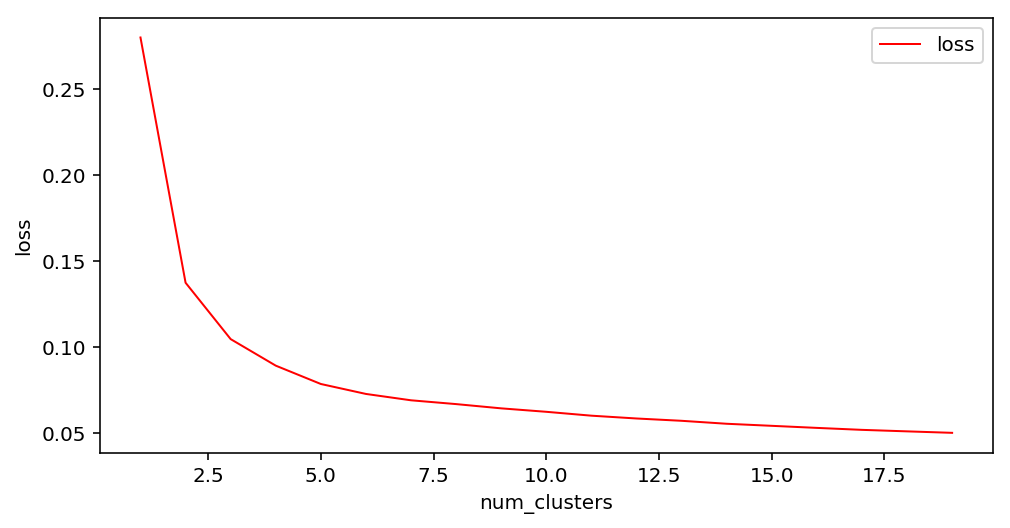

In [641]:
test(sent2vec, tokTexts)

In [679]:
result = train(sent2vec, tokTexts, num_clusters=3, showLable=True)

Top terms per cluster:
frozenset({'34', '03', '39', '32', '月', '75', '86', '59', '37', '拟', '85', '200', '150', '68', '52', '83', '06', '为', '13', '42', '因为', '00', '500', '中', '46', '28', '74', '27', '30', '58', '98', '%', '09', '02', '73', '84', '87', '56', '70', '69', '亿元', '2000', '77', '100', '45', '62', '33', '54', '71', '16', '新', '47', '已', '01', '99', '日', '53', '同比', '65', '88', '48', '晚间', '44', '57', '50', '90', '2017', '07', '67', '76', '41', '05', '40', '96', '35', '23', '94', '81', '约', '04', '300', '不', '2016', '5000', '93', '80', '29', '11', '55', '3000', '66', '31', '14', '19', '20', '因', '38', '将', '21', '2018', '15', '49', '10', '股', '72', '4000', '95', '79', '60', '82', '年', '26', '20142016', '08', '后', '24', '89', '2015', '92', '78', '25', '2014', '51', '63', '万元', '64', '1000', '91', '36', '元', '61', '97', '18', '22', '12', '43', '2019', '17'})
Cluster 1: 财经 规模 来自 毛利 近期 海外 超过 波动 收盘 方式 提出
Cluster 2: 成本 规模 接受 作为 提出 财经 股权 技术 来自 收市价 收盘
Cluster 3: 规模 财经 来自 超过 收盘 提出 海外

In [643]:
result = [result[1][i] for i in range(len(result[1])) if label[i] == 1]
print ('Casual Cluster distribution:')
print (dict([(i, result.count(i)) for i in result]))

Casual Cluster distribution:
{0: 394, 1: 155, 2: 275}


## Causal

  3%|▎         | 2/79 [00:00<00:07, 10.39it/s]

824 Sentence
Cluster distribution:
{0: 824}
1 0.9506621122926099
Cluster distribution:
{0: 203, 1: 621}
2 0.9237384135370649
Cluster distribution:
{0: 116, 2: 419, 1: 289}
3 0.91183392580313


  5%|▌         | 4/79 [00:00<00:09,  8.08it/s]

Cluster distribution:
{2: 192, 0: 319, 3: 195, 1: 118}
4 0.9020456953006806
Cluster distribution:

  8%|▊         | 6/79 [00:00<00:10,  6.99it/s]


{3: 109, 0: 384, 2: 49, 1: 193, 4: 89}
5 0.8847722784649481
Cluster distribution:
{2: 63, 4: 352, 3: 120, 1: 150, 5: 86, 0: 53}
6 0.8800785000257646


 10%|█         | 8/79 [00:01<00:09,  7.25it/s]

Cluster distribution:
{3: 89, 4: 83, 0: 341, 6: 124, 1: 94, 5: 48, 2: 45}
7 0.8702145128100428
Cluster distribution:
{0: 107, 7: 246, 6: 53, 4: 33, 1: 133, 2: 92, 5: 132, 3: 28}
8 0.8580392273547494


 13%|█▎        | 10/79 [00:01<00:11,  5.95it/s]

Cluster distribution:
{6: 108, 8: 250, 3: 99, 0: 46, 7: 20, 4: 86, 2: 59, 1: 82, 5: 74}
9 0.8539208618961794
Cluster distribution:
{7: 73, 3: 245, 9: 47, 5: 71, 6: 77, 1: 65, 4: 68, 0: 81, 8: 28, 2: 69}
10 0.8496777381823063


 15%|█▌        | 12/79 [00:01<00:10,  6.42it/s]

Cluster distribution:
{9: 101, 7: 47, 3: 87, 4: 64, 2: 130, 6: 30, 10: 79, 5: 82, 1: 68, 0: 47, 8: 89}
11 0.8490625686972202
Cluster distribution:
{10: 89, 8: 204, 2: 41, 1: 33, 0: 90, 3: 88, 5: 67, 6: 42, 11: 34, 7: 41, 4: 64, 9: 31}
12 0.8405609449465986


 16%|█▋        | 13/79 [00:02<00:09,  6.61it/s]

Cluster distribution:
{4: 82, 9: 213, 6: 76, 11: 75, 7: 55, 5: 30, 12: 37, 3: 75, 2: 45, 10: 54, 8: 14, 0: 27, 1: 41}
13 0.8290559469929576


 19%|█▉        | 15/79 [00:02<00:11,  5.67it/s]

Cluster distribution:
{8: 97, 3: 197, 11: 72, 13: 47, 6: 61, 7: 19, 4: 19, 5: 92, 2: 47, 10: 43, 9: 41, 0: 19, 1: 49, 12: 21}
14 0.8254109418394935
Cluster distribution:
{9: 46, 7: 117, 13: 51, 8: 30, 5: 88, 4: 47, 0: 40, 3: 56, 6: 68, 1: 65, 10: 31, 14: 96, 12: 33, 2: 21, 11: 35}
15 0.8305217920855156


 22%|██▏       | 17/79 [00:02<00:09,  6.26it/s]

Cluster distribution:
{14: 59, 4: 95, 6: 80, 3: 26, 8: 19, 9: 60, 1: 82, 0: 33, 7: 72, 2: 67, 5: 56, 11: 54, 10: 24, 15: 27, 12: 53, 13: 17}
16 0.8169561797322165
Cluster distribution:
{13: 50, 0: 115, 3: 63, 2: 52, 16: 18, 14: 70, 7: 48, 10: 85, 8: 25, 5: 50, 12: 46, 15: 13, 6: 24, 1: 43, 4: 48, 11: 25, 9: 49}
17 0.8103927276238488


 24%|██▍       | 19/79 [00:03<00:09,  6.55it/s]

Cluster distribution:
{5: 54, 7: 102, 3: 43, 17: 37, 12: 20, 11: 37, 10: 49, 6: 63, 8: 29, 9: 83, 2: 46, 13: 42, 14: 64, 16: 11, 4: 31, 15: 44, 0: 32, 1: 37}
18 0.8090480580298731
Cluster distribution:
{11: 49, 12: 178, 17: 35, 14: 40, 6: 34, 13: 14, 9: 35, 16: 55, 0: 26, 8: 50, 15: 50, 3: 38, 1: 32, 7: 40, 10: 22, 4: 24, 18: 19, 5: 25, 2: 58}
19 0.8038604735211969


 27%|██▋       | 21/79 [00:03<00:09,  6.12it/s]

Cluster distribution:
{19: 32, 11: 147, 13: 46, 9: 40, 14: 44, 2: 19, 0: 35, 6: 55, 10: 27, 17: 72, 7: 42, 8: 30, 5: 41, 18: 21, 4: 28, 3: 16, 15: 37, 12: 40, 16: 42, 1: 10}
20 0.803275707929617
Cluster distribution:
{7: 74, 4: 82, 9: 43, 1: 45, 20: 22, 19: 19, 13: 28, 3: 71, 8: 48, 2: 25, 17: 51, 12: 29, 5: 32, 18: 38, 15: 61, 11: 22, 14: 29, 10: 14, 16: 26, 6: 48, 0: 17}
21 0.8004118733583949


 28%|██▊       | 22/79 [00:03<00:08,  6.56it/s]

Cluster distribution:
{1: 45, 13: 79, 17: 61, 2: 39, 4: 55, 7: 18, 12: 25, 3: 42, 5: 72, 16: 33, 20: 29, 15: 29, 14: 26, 21: 48, 6: 23, 0: 37, 11: 14, 10: 37, 19: 24, 8: 28, 9: 40, 18: 20}
22 0.7935432195444871


 30%|███       | 24/79 [00:03<00:09,  5.90it/s]

Cluster distribution:
{9: 36, 22: 57, 18: 29, 11: 54, 6: 53, 12: 29, 14: 120, 2: 67, 3: 39, 10: 36, 15: 21, 7: 25, 17: 30, 0: 17, 20: 19, 8: 24, 5: 23, 19: 14, 4: 34, 21: 39, 13: 17, 1: 28, 16: 13}
23 0.7905902645514978
Cluster distribution:
{14: 56, 10: 101, 0: 43, 7: 41, 12: 35, 8: 19, 13: 22, 16: 30, 23: 23, 21: 38, 6: 40, 15: 41, 9: 56, 22: 27, 19: 41, 18: 36, 11: 22, 5: 30, 2: 14, 17: 22, 4: 24, 3: 15, 20: 11, 1: 37}
24 0.7854729855110467


 33%|███▎      | 26/79 [00:04<00:09,  5.88it/s]

Cluster distribution:
{1: 41, 3: 156, 8: 57, 13: 17, 19: 19, 11: 47, 9: 32, 21: 13, 7: 19, 6: 30, 2: 26, 16: 49, 14: 26, 10: 40, 4: 28, 5: 25, 15: 26, 20: 14, 18: 15, 23: 29, 12: 35, 22: 14, 0: 16, 24: 25, 17: 25}
25 0.7777249146305032
Cluster distribution:
{1: 53, 23: 36, 0: 19, 5: 40, 22: 46, 25: 11, 4: 90, 7: 29, 3: 64, 2: 25, 10: 31, 8: 25, 21: 28, 12: 29, 11: 26, 6: 10, 18: 10, 17: 27, 19: 47, 16: 14, 20: 37, 15: 25, 13: 17, 9: 27, 24: 15, 14: 43}
26 0.7810126840097844


 35%|███▌      | 28/79 [00:04<00:08,  6.02it/s]

Cluster distribution:
{10: 30, 23: 116, 21: 33, 12: 40, 15: 41, 6: 14, 25: 32, 22: 44, 19: 14, 4: 34, 2: 33, 13: 25, 3: 47, 0: 14, 20: 32, 14: 11, 11: 21, 1: 36, 7: 25, 17: 20, 24: 27, 9: 22, 18: 17, 16: 27, 8: 18, 5: 36, 26: 15}
27 0.7807587738031385
Cluster distribution:
{27: 39, 20: 82, 9: 31, 10: 29, 17: 25, 6: 37, 21: 29, 11: 46, 4: 36, 14: 29, 25: 25, 19: 17, 2: 51, 23: 28, 22: 35, 26: 18, 18: 30, 16: 12, 8: 23, 5: 22, 12: 30, 0: 16, 1: 19, 13: 24, 7: 36, 3: 25, 24: 17, 15: 13}
28 0.77571058203789


 38%|███▊      | 30/79 [00:04<00:07,  6.33it/s]

Cluster distribution:
{15: 55, 23: 124, 2: 30, 20: 22, 12: 30, 3: 27, 14: 25, 0: 27, 28: 16, 24: 28, 13: 39, 6: 31, 27: 10, 5: 48, 11: 12, 19: 21, 25: 10, 26: 37, 21: 25, 18: 14, 7: 32, 9: 19, 4: 27, 16: 21, 10: 17, 8: 36, 22: 15, 17: 9, 1: 17}
29 0.7727696041593333
Cluster distribution:
{25: 35, 0: 50, 26: 24, 1: 25, 2: 30, 12: 31, 27: 34, 23: 32, 5: 52, 18: 38, 10: 38, 21: 25, 28: 27, 8: 33, 15: 6, 16: 24, 24: 24, 17: 23, 19: 42, 7: 14, 22: 44, 6: 23, 11: 23, 14: 15, 4: 32, 9: 27, 29: 18, 3: 9, 20: 12, 13: 14}
30 0.7783158214047761


 41%|████      | 32/79 [00:05<00:08,  5.84it/s]

Cluster distribution:
{10: 41, 22: 25, 12: 43, 25: 38, 16: 27, 21: 19, 29: 24, 26: 25, 9: 33, 1: 20, 20: 26, 24: 28, 28: 16, 15: 38, 11: 29, 6: 21, 23: 22, 14: 17, 19: 35, 4: 30, 0: 39, 7: 19, 2: 27, 5: 28, 8: 10, 13: 52, 18: 21, 30: 20, 3: 18, 27: 19, 17: 14}
31 0.7710676961316706
Cluster distribution:
{9: 41, 20: 58, 17: 39, 6: 18, 21: 38, 11: 19, 22: 34, 24: 26, 30: 29, 0: 34, 5: 31, 15: 20, 12: 17, 7: 25, 29: 28, 1: 22, 3: 11, 18: 23, 27: 20, 28: 23, 31: 16, 13: 14, 19: 27, 2: 24, 25: 24, 10: 30, 16: 29, 26: 35, 23: 13, 14: 19, 4: 19, 8: 18}
32 0.7636547726554503


 43%|████▎     | 34/79 [00:05<00:07,  6.21it/s]

Cluster distribution:
{1: 41, 32: 73, 14: 28, 3: 52, 10: 19, 21: 23, 22: 32, 23: 35, 31: 24, 27: 27, 19: 29, 28: 17, 6: 20, 18: 37, 30: 26, 12: 20, 24: 13, 17: 17, 25: 34, 29: 21, 4: 14, 13: 21, 8: 30, 9: 16, 20: 15, 0: 12, 5: 12, 11: 26, 15: 12, 16: 19, 7: 34, 26: 11, 2: 14}
33 0.7599972143129202
Cluster distribution:
{19: 24, 16: 43, 28: 22, 11: 23, 10: 41, 2: 18, 27: 18, 8: 22, 0: 31, 18: 25, 9: 19, 22: 34, 26: 24, 5: 32, 6: 28, 7: 34, 15: 33, 29: 14, 14: 40, 33: 29, 13: 21, 3: 14, 30: 23, 12: 15, 21: 19, 24: 23, 23: 18, 31: 19, 32: 14, 25: 27, 20: 17, 1: 20, 4: 26, 17: 14}
34 0.7577011121574551


 46%|████▌     | 36/79 [00:05<00:07,  5.98it/s]

Cluster distribution:
{14: 38, 23: 34, 32: 18, 6: 15, 1: 32, 7: 19, 25: 15, 17: 15, 13: 26, 10: 27, 0: 33, 21: 21, 26: 21, 31: 33, 19: 39, 28: 29, 15: 25, 5: 24, 33: 16, 2: 23, 20: 28, 9: 25, 11: 40, 30: 29, 12: 14, 4: 23, 3: 8, 8: 15, 16: 16, 27: 25, 34: 24, 24: 23, 22: 12, 29: 17, 18: 22}
35 0.7567821104136487
Cluster distribution:
{12: 34, 19: 22, 7: 22, 24: 49, 25: 38, 10: 9, 32: 21, 35: 25, 30: 22, 34: 29, 21: 29, 5: 26, 16: 40, 11: 42, 28: 15, 27: 23, 26: 15, 17: 21, 15: 13, 18: 21, 0: 16, 14: 20, 23: 17, 13: 23, 4: 25, 31: 21, 1: 25, 9: 29, 3: 11, 22: 13, 8: 24, 33: 14, 29: 14, 2: 9, 20: 18, 6: 29}
36 0.7579416560794847


 48%|████▊     | 38/79 [00:06<00:07,  5.65it/s]

Cluster distribution:
{0: 22, 21: 25, 14: 19, 16: 21, 3: 33, 5: 19, 22: 41, 30: 28, 35: 24, 8: 33, 7: 57, 28: 17, 20: 19, 19: 11, 2: 26, 32: 14, 1: 29, 36: 30, 27: 28, 13: 18, 25: 27, 26: 14, 10: 13, 34: 19, 15: 22, 6: 14, 11: 30, 18: 6, 33: 20, 17: 15, 23: 22, 12: 34, 4: 12, 31: 19, 29: 16, 9: 16, 24: 11}
37 0.7505043854438022
Cluster distribution:
{3: 42, 34: 71, 10: 25, 13: 34, 22: 36, 35: 12, 33: 20, 28: 11, 9: 54, 1: 16, 32: 11, 11: 26, 29: 9, 14: 19, 31: 17, 24: 22, 21: 12, 17: 24, 12: 15, 26: 14, 6: 42, 8: 21, 27: 28, 23: 19, 18: 25, 15: 19, 36: 10, 5: 16, 30: 17, 7: 12, 0: 9, 4: 10, 37: 30, 20: 13, 19: 16, 2: 8, 16: 19, 25: 20}
38 0.7496611089824681


 49%|████▉     | 39/79 [00:06<00:06,  5.76it/s]

Cluster distribution:
{11: 21, 3: 36, 35: 20, 5: 26, 22: 56, 17: 19, 13: 26, 25: 24, 6: 15, 36: 12, 27: 10, 34: 12, 23: 25, 33: 32, 9: 31, 18: 33, 28: 20, 2: 31, 30: 13, 37: 25, 8: 14, 4: 24, 31: 19, 0: 14, 14: 22, 29: 24, 12: 16, 15: 15, 16: 33, 24: 18, 21: 8, 7: 19, 1: 19, 20: 12, 32: 21, 10: 22, 26: 14, 38: 17, 19: 6}
39 0.7480552482979069
Cluster distribution:

 52%|█████▏    | 41/79 [00:06<00:07,  5.42it/s]


{33: 32, 20: 46, 8: 32, 31: 21, 10: 36, 26: 15, 17: 42, 9: 24, 6: 21, 39: 17, 27: 27, 13: 20, 11: 26, 30: 28, 25: 13, 28: 22, 16: 14, 12: 19, 1: 16, 3: 14, 7: 15, 2: 26, 21: 18, 32: 24, 34: 21, 29: 25, 23: 16, 38: 15, 19: 32, 35: 18, 0: 12, 22: 24, 24: 14, 14: 10, 36: 14, 5: 6, 15: 16, 37: 10, 4: 14, 18: 9}
40 0.7379275992143733
Cluster distribution:
{37: 37, 40: 38, 31: 22, 14: 19, 3: 24, 4: 18, 8: 21, 18: 23, 20: 22, 22: 24, 2: 41, 5: 23, 12: 28, 28: 42, 24: 26, 29: 29, 26: 17, 17: 19, 21: 8, 15: 13, 23: 17, 36: 14, 30: 19, 32: 12, 25: 13, 34: 15, 6: 20, 10: 19, 38: 16, 11: 18, 19: 18, 16: 16, 9: 15, 7: 19, 39: 20, 0: 15, 13: 13, 33: 10, 35: 13, 1: 18, 27: 10}
41 0.7406663520273878


 54%|█████▍    | 43/79 [00:07<00:06,  5.45it/s]

Cluster distribution:
{18: 30, 26: 24, 23: 23, 2: 23, 16: 37, 35: 11, 38: 46, 27: 16, 36: 24, 11: 21, 25: 19, 33: 26, 37: 29, 32: 37, 30: 26, 6: 26, 39: 15, 34: 9, 0: 10, 4: 22, 15: 23, 12: 14, 19: 21, 40: 21, 31: 13, 8: 11, 14: 15, 22: 22, 24: 9, 29: 15, 9: 27, 17: 15, 13: 9, 5: 22, 21: 20, 41: 11, 20: 15, 3: 11, 7: 14, 10: 9, 1: 16, 28: 17}
42 0.7419892571447788
Cluster distribution:
{2: 13, 39: 33, 29: 21, 18: 17, 24: 35, 5: 18, 34: 16, 37: 48, 10: 23, 1: 21, 23: 13, 36: 14, 33: 20, 4: 35, 14: 8, 11: 24, 6: 17, 16: 18, 28: 16, 25: 21, 12: 22, 35: 7, 40: 21, 30: 14, 38: 24, 15: 14, 0: 7, 20: 18, 7: 25, 26: 18, 41: 10, 22: 29, 27: 15, 8: 12, 42: 16, 3: 15, 13: 23, 21: 27, 32: 24, 17: 12, 9: 20, 19: 7, 31: 13}
43 0.7377047761497117


 56%|█████▌    | 44/79 [00:07<00:06,  5.47it/s]

Cluster distribution:
{9: 37, 22: 34, 28: 24, 41: 23, 2: 30, 14: 18, 10: 25, 23: 23, 17: 10, 5: 12, 4: 20, 8: 26, 32: 27, 20: 15, 27: 21, 6: 20, 1: 25, 37: 19, 25: 36, 13: 14, 36: 19, 24: 12, 40: 15, 7: 21, 31: 13, 11: 18, 0: 11, 12: 7, 39: 9, 29: 13, 30: 20, 34: 15, 18: 20, 21: 16, 43: 14, 26: 21, 19: 14, 3: 14, 35: 13, 16: 12, 15: 31, 38: 13, 33: 9, 42: 15}
44 0.7319753444435655


 58%|█████▊    | 46/79 [00:07<00:05,  5.60it/s]

Cluster distribution:
{6: 14, 4: 27, 11: 21, 21: 27, 29: 17, 13: 16, 33: 9, 39: 32, 10: 53, 35: 11, 42: 25, 17: 16, 44: 28, 41: 15, 9: 12, 32: 21, 20: 12, 40: 11, 8: 40, 31: 22, 38: 15, 15: 19, 28: 13, 12: 14, 24: 16, 22: 15, 26: 8, 0: 25, 18: 23, 25: 7, 16: 21, 36: 25, 27: 9, 3: 10, 23: 20, 19: 22, 14: 13, 30: 20, 1: 19, 7: 14, 5: 6, 2: 11, 37: 17, 43: 16, 34: 17}
45 0.73188219523504
Cluster distribution:
{40: 39, 42: 31, 23: 16, 6: 15, 7: 34, 36: 15, 27: 13, 44: 9, 8: 27, 12: 24, 18: 13, 28: 16, 1: 12, 20: 13, 21: 17, 34: 25, 2: 28, 5: 34, 17: 26, 33: 20, 24: 15, 35: 15, 31: 23, 29: 21, 10: 26, 13: 29, 3: 22, 25: 14, 15: 8, 26: 14, 14: 15, 37: 15, 16: 13, 41: 19, 32: 12, 30: 19, 4: 8, 22: 14, 0: 8, 19: 16, 38: 17, 11: 13, 43: 8, 45: 13, 9: 9, 39: 11}
46 0.7355713885574077


 61%|██████    | 48/79 [00:08<00:05,  5.91it/s]

Cluster distribution:
{7: 9, 3: 31, 19: 15, 40: 18, 11: 32, 21: 19, 4: 13, 24: 18, 41: 13, 1: 24, 44: 11, 15: 15, 5: 26, 30: 32, 28: 31, 23: 20, 32: 17, 36: 13, 38: 13, 13: 14, 0: 22, 2: 13, 26: 23, 9: 14, 35: 12, 12: 13, 6: 15, 10: 22, 33: 20, 45: 19, 27: 15, 37: 12, 43: 16, 39: 30, 22: 16, 18: 10, 31: 11, 17: 21, 46: 13, 29: 13, 14: 32, 42: 10, 8: 26, 20: 8, 34: 12, 25: 15, 16: 7}
47 0.7271236152646888
Cluster distribution:
{5: 36, 45: 33, 32: 17, 13: 20, 29: 28, 23: 11, 37: 16, 1: 35, 18: 23, 19: 27, 20: 20, 41: 13, 7: 14, 25: 15, 21: 8, 36: 27, 47: 20, 9: 16, 38: 11, 4: 18, 22: 21, 15: 23, 28: 22, 6: 12, 14: 14, 30: 9, 43: 18, 27: 17, 34: 18, 12: 16, 17: 10, 2: 18, 42: 22, 0: 19, 44: 16, 33: 14, 40: 14, 11: 6, 46: 9, 31: 13, 39: 19, 3: 13, 16: 9, 8: 18, 24: 21, 10: 10, 26: 5, 35: 10}
48 0.7249435024325704


 63%|██████▎   | 50/79 [00:08<00:04,  6.11it/s]

Cluster distribution:
{25: 21, 6: 39, 31: 19, 16: 10, 35: 40, 7: 19, 29: 16, 20: 9, 18: 24, 21: 23, 0: 17, 10: 14, 40: 16, 9: 16, 4: 17, 1: 38, 24: 26, 34: 21, 22: 16, 37: 15, 17: 22, 45: 12, 46: 16, 28: 20, 3: 14, 42: 11, 15: 19, 36: 20, 2: 16, 13: 24, 23: 10, 26: 20, 5: 15, 44: 18, 32: 8, 11: 16, 47: 12, 12: 13, 27: 8, 8: 13, 19: 17, 48: 5, 43: 10, 41: 10, 33: 7, 30: 19, 38: 14, 39: 15, 14: 4}
49 0.7236123797971515
Cluster distribution:
{24: 29, 19: 15, 1: 25, 22: 24, 41: 22, 11: 18, 20: 14, 4: 7, 27: 18, 7: 25, 17: 20, 33: 12, 37: 14, 40: 6, 38: 9, 21: 27, 31: 17, 15: 12, 32: 14, 47: 19, 48: 15, 8: 18, 30: 12, 36: 14, 26: 19, 18: 14, 28: 11, 12: 19, 3: 20, 23: 15, 14: 22, 35: 21, 46: 21, 13: 18, 45: 16, 0: 14, 10: 8, 2: 30, 44: 8, 6: 18, 43: 28, 39: 11, 49: 15, 5: 9, 34: 14, 9: 11, 16: 28, 42: 11, 25: 8, 29: 9}
50 0.7239193026245444


 66%|██████▌   | 52/79 [00:08<00:04,  5.94it/s]

Cluster distribution:
{29: 15, 15: 22, 16: 20, 17: 31, 23: 37, 43: 8, 25: 13, 34: 39, 35: 13, 44: 27, 45: 15, 8: 37, 50: 8, 28: 12, 21: 16, 14: 26, 33: 23, 37: 15, 2: 18, 3: 9, 26: 11, 12: 18, 9: 25, 32: 8, 41: 16, 1: 18, 31: 4, 46: 17, 0: 21, 49: 14, 7: 13, 39: 10, 20: 14, 18: 26, 13: 16, 24: 11, 38: 10, 11: 14, 19: 8, 4: 6, 48: 13, 47: 7, 42: 9, 6: 19, 27: 11, 30: 15, 22: 11, 10: 14, 5: 10, 36: 13, 40: 18}
51 0.7210443409527109
Cluster distribution:
{3: 34, 51: 21, 31: 14, 9: 26, 30: 28, 16: 12, 34: 18, 44: 8, 1: 13, 37: 31, 27: 16, 29: 9, 12: 15, 19: 7, 23: 17, 40: 21, 10: 32, 32: 13, 45: 17, 6: 10, 11: 15, 36: 18, 41: 15, 4: 11, 20: 20, 17: 14, 14: 16, 25: 14, 33: 21, 39: 12, 0: 10, 7: 21, 8: 20, 42: 11, 2: 6, 38: 12, 47: 24, 13: 19, 49: 9, 50: 11, 18: 8, 24: 9, 28: 12, 46: 23, 35: 11, 26: 16, 5: 19, 15: 18, 22: 16, 21: 9, 43: 11, 48: 11}
52 0.7243024224481441


 68%|██████▊   | 54/79 [00:09<00:04,  5.67it/s]

Cluster distribution:
{1: 31, 28: 24, 20: 21, 47: 15, 7: 15, 3: 15, 51: 16, 25: 19, 24: 18, 46: 28, 39: 10, 15: 8, 45: 7, 12: 22, 4: 26, 42: 22, 9: 31, 33: 15, 26: 28, 38: 18, 17: 10, 0: 26, 27: 20, 8: 14, 36: 13, 22: 10, 21: 13, 14: 26, 49: 13, 50: 15, 19: 16, 5: 10, 11: 13, 10: 21, 52: 15, 35: 16, 48: 16, 44: 7, 32: 16, 18: 9, 40: 7, 29: 7, 13: 9, 6: 12, 23: 15, 16: 10, 41: 8, 31: 8, 30: 7, 34: 18, 37: 8, 43: 17, 2: 10}
53 0.7142006179453483
Cluster distribution:
{50: 27, 41: 11, 24: 21, 5: 20, 8: 19, 40: 13, 21: 18, 52: 17, 23: 12, 6: 21, 31: 13, 45: 12, 46: 22, 42: 32, 2: 9, 47: 15, 18: 19, 25: 15, 33: 8, 49: 7, 36: 20, 16: 10, 30: 9, 35: 21, 22: 31, 34: 29, 9: 15, 37: 14, 10: 12, 20: 18, 14: 17, 3: 23, 7: 22, 39: 13, 53: 8, 43: 21, 51: 16, 26: 13, 32: 10, 15: 15, 44: 15, 27: 9, 48: 14, 11: 12, 29: 7, 17: 8, 28: 6, 13: 14, 19: 13, 38: 13, 12: 14, 4: 19, 1: 7, 0: 5}
54 0.715834004642136


 71%|███████   | 56/79 [00:09<00:04,  5.47it/s]

Cluster distribution:
{7: 19, 5: 7, 48: 10, 9: 26, 49: 20, 18: 10, 32: 13, 27: 10, 1: 13, 38: 22, 8: 20, 24: 17, 19: 15, 10: 17, 15: 26, 11: 43, 4: 23, 20: 14, 34: 18, 21: 10, 23: 10, 29: 11, 41: 16, 46: 15, 40: 17, 42: 23, 28: 12, 6: 14, 39: 13, 31: 20, 22: 13, 25: 12, 45: 25, 30: 14, 3: 20, 36: 17, 53: 19, 35: 15, 43: 11, 44: 9, 13: 18, 14: 7, 33: 12, 50: 11, 2: 19, 12: 9, 16: 13, 52: 10, 54: 7, 17: 11, 51: 11, 26: 13, 0: 6, 47: 11, 37: 7}
55 0.7074806245098602
Cluster distribution:
{20: 25, 53: 17, 11: 21, 12: 4, 19: 23, 45: 13, 35: 11, 39: 10, 51: 15, 18: 19, 8: 25, 29: 15, 41: 15, 13: 14, 10: 11, 36: 15, 40: 24, 49: 22, 30: 19, 27: 22, 7: 10, 23: 11, 17: 14, 42: 15, 54: 10, 14: 31, 47: 15, 6: 14, 28: 10, 3: 15, 1: 14, 38: 11, 31: 13, 50: 8, 24: 16, 46: 10, 37: 12, 43: 16, 15: 14, 16: 10, 26: 24, 0: 23, 25: 8, 9: 8, 52: 15, 2: 10, 22: 19, 21: 7, 5: 21, 48: 13, 4: 6, 34: 13, 44: 6, 33: 9, 32: 17, 55: 16}
56 0.708798606163814


 73%|███████▎  | 58/79 [00:09<00:03,  5.76it/s]

Cluster distribution:
{15: 16, 29: 31, 54: 13, 5: 20, 12: 27, 56: 12, 28: 18, 26: 16, 51: 19, 17: 21, 10: 9, 53: 11, 27: 11, 14: 19, 24: 13, 50: 21, 41: 12, 32: 11, 19: 11, 48: 14, 2: 14, 37: 13, 55: 9, 3: 25, 42: 13, 16: 14, 35: 14, 46: 11, 23: 9, 13: 23, 18: 14, 22: 7, 47: 21, 34: 10, 0: 8, 43: 10, 21: 11, 44: 12, 25: 15, 36: 9, 31: 10, 11: 8, 33: 6, 52: 12, 9: 11, 6: 19, 49: 10, 20: 13, 39: 12, 1: 37, 38: 17, 7: 9, 45: 12, 8: 8, 40: 19, 4: 19, 30: 15}
57 0.7038287489869978
Cluster distribution:
{1: 23, 56: 18, 23: 22, 50: 15, 19: 33, 7: 14, 27: 34, 3: 17, 16: 14, 36: 22, 4: 12, 43: 9, 49: 9, 26: 13, 6: 17, 25: 30, 9: 20, 10: 21, 42: 11, 44: 16, 14: 23, 2: 17, 15: 17, 17: 14, 46: 9, 8: 11, 0: 12, 34: 7, 57: 10, 18: 13, 5: 21, 55: 11, 51: 17, 24: 16, 31: 6, 30: 9, 39: 15, 37: 10, 40: 6, 33: 12, 35: 8, 52: 8, 28: 15, 12: 16, 29: 9, 20: 14, 53: 14, 47: 11, 54: 8, 32: 16, 45: 10, 38: 12, 21: 15, 22: 15, 11: 3, 13: 7, 41: 12, 48: 5}
58 0.7070595228480007


 76%|███████▌  | 60/79 [00:10<00:03,  5.69it/s]

Cluster distribution:
{7: 16, 45: 13, 12: 18, 58: 16, 4: 26, 10: 11, 36: 10, 28: 15, 18: 16, 30: 18, 52: 20, 33: 12, 55: 13, 22: 5, 44: 16, 51: 12, 24: 13, 31: 8, 53: 17, 46: 15, 37: 11, 17: 23, 39: 10, 29: 20, 19: 16, 35: 17, 27: 15, 9: 17, 16: 9, 23: 20, 48: 10, 57: 12, 2: 15, 14: 25, 3: 24, 38: 11, 21: 10, 50: 8, 43: 20, 41: 18, 32: 13, 34: 16, 0: 7, 13: 14, 40: 9, 56: 15, 49: 17, 42: 11, 15: 12, 25: 8, 6: 15, 5: 14, 11: 19, 8: 8, 26: 17, 54: 7, 20: 13, 47: 6, 1: 2}
59 0.7095883559726356
Cluster distribution:
{51: 12, 28: 26, 56: 17, 55: 14, 33: 21, 19: 14, 39: 11, 34: 9, 7: 12, 30: 12, 24: 16, 32: 21, 12: 8, 43: 17, 46: 20, 25: 7, 49: 16, 44: 11, 9: 19, 40: 26, 18: 8, 37: 11, 16: 13, 14: 20, 21: 18, 52: 13, 22: 16, 59: 10, 6: 14, 41: 20, 1: 17, 38: 14, 5: 15, 31: 16, 53: 12, 20: 15, 48: 7, 36: 17, 27: 15, 35: 11, 8: 14, 23: 19, 4: 12, 54: 9, 26: 11, 50: 7, 15: 11, 2: 12, 42: 13, 29: 13, 58: 17, 13: 15, 3: 13, 47: 7, 10: 10, 0: 12, 45: 14, 11: 7, 57: 9, 17: 8}
60 0.7002986388360058


 78%|███████▊  | 62/79 [00:10<00:03,  5.60it/s]

Cluster distribution:
{28: 25, 59: 13, 15: 17, 23: 22, 2: 18, 6: 11, 42: 16, 45: 13, 38: 10, 58: 13, 11: 20, 41: 8, 0: 9, 32: 17, 1: 31, 7: 23, 39: 10, 26: 8, 14: 10, 55: 7, 36: 16, 17: 22, 31: 12, 51: 6, 60: 24, 53: 15, 50: 12, 18: 13, 30: 14, 21: 15, 19: 16, 46: 16, 20: 26, 27: 12, 9: 17, 48: 15, 10: 10, 12: 11, 25: 14, 57: 8, 34: 7, 52: 9, 56: 9, 16: 17, 24: 16, 8: 13, 3: 10, 33: 10, 29: 19, 40: 8, 35: 21, 49: 9, 37: 9, 13: 11, 54: 20, 4: 6, 22: 7, 47: 7, 43: 6, 44: 9, 5: 6}
61 0.7005599118875055
Cluster distribution:
{35: 25, 48: 20, 46: 17, 21: 7, 56: 32, 20: 16, 55: 19, 41: 11, 52: 19, 53: 9, 49: 11, 15: 14, 39: 8, 30: 14, 2: 31, 28: 18, 12: 17, 10: 14, 51: 20, 17: 16, 34: 11, 18: 18, 54: 14, 24: 14, 5: 15, 45: 15, 13: 13, 26: 21, 57: 10, 38: 22, 16: 7, 11: 20, 50: 4, 43: 10, 60: 10, 27: 10, 31: 14, 1: 18, 9: 6, 22: 7, 61: 15, 59: 14, 44: 13, 23: 4, 14: 14, 6: 6, 33: 12, 29: 17, 40: 10, 4: 15, 42: 10, 36: 11, 8: 7, 7: 12, 0: 22, 37: 8, 3: 2, 19: 7, 25: 12, 58: 7, 47: 5, 32: 4}
62

 81%|████████  | 64/79 [00:10<00:02,  5.78it/s]

Cluster distribution:
{9: 33, 39: 7, 10: 14, 1: 12, 57: 13, 20: 14, 21: 15, 58: 12, 24: 14, 53: 21, 0: 8, 42: 8, 32: 11, 41: 18, 43: 9, 26: 15, 5: 18, 8: 28, 19: 17, 40: 14, 51: 8, 14: 13, 48: 13, 6: 17, 45: 10, 60: 14, 17: 12, 2: 29, 22: 14, 4: 15, 3: 19, 33: 11, 34: 14, 54: 8, 13: 21, 25: 12, 15: 7, 18: 12, 52: 9, 47: 22, 12: 16, 27: 12, 36: 6, 55: 14, 56: 18, 49: 17, 37: 13, 59: 7, 46: 13, 23: 6, 50: 15, 31: 7, 16: 13, 35: 12, 30: 8, 62: 7, 28: 9, 7: 8, 29: 17, 61: 4, 44: 9, 11: 6, 38: 6}
63 0.6916641525275922
Cluster distribution:
{11: 26, 26: 18, 14: 10, 62: 9, 45: 23, 22: 17, 27: 8, 58: 10, 13: 18, 2: 8, 4: 31, 12: 22, 18: 10, 44: 12, 63: 9, 8: 12, 28: 22, 50: 4, 10: 16, 37: 12, 48: 8, 0: 15, 52: 18, 46: 4, 29: 15, 33: 14, 24: 15, 17: 14, 36: 12, 1: 27, 16: 7, 20: 6, 55: 14, 60: 10, 47: 14, 39: 14, 51: 13, 30: 15, 49: 23, 42: 11, 40: 8, 3: 18, 25: 9, 21: 8, 34: 10, 32: 5, 23: 13, 35: 11, 15: 13, 19: 7, 38: 15, 59: 13, 7: 13, 9: 10, 57: 6, 43: 21, 54: 8, 6: 17, 56: 7, 5: 7, 61: 11

 84%|████████▎ | 66/79 [00:11<00:02,  5.78it/s]

Cluster distribution:
{12: 35, 58: 7, 30: 12, 43: 13, 44: 22, 38: 9, 63: 13, 41: 12, 7: 15, 16: 17, 60: 20, 47: 15, 50: 6, 34: 12, 53: 8, 4: 15, 21: 23, 36: 22, 49: 11, 42: 10, 13: 10, 29: 16, 3: 11, 56: 16, 54: 15, 22: 18, 61: 16, 37: 13, 23: 10, 25: 10, 15: 11, 46: 9, 6: 14, 27: 17, 8: 20, 51: 15, 57: 12, 24: 14, 59: 11, 64: 11, 55: 25, 0: 10, 52: 8, 2: 16, 19: 11, 48: 10, 17: 9, 62: 7, 31: 12, 35: 14, 20: 9, 9: 10, 1: 17, 45: 7, 33: 8, 28: 9, 26: 16, 39: 4, 18: 11, 40: 10, 11: 14, 5: 8, 14: 2, 32: 8, 10: 3}
65 0.6855920929144096
Cluster distribution:
{50: 20, 33: 13, 5: 17, 6: 25, 16: 14, 11: 13, 7: 14, 37: 16, 40: 16, 53: 18, 1: 22, 23: 13, 56: 11, 0: 7, 41: 9, 26: 14, 29: 13, 15: 32, 60: 9, 13: 17, 35: 19, 39: 8, 24: 12, 34: 14, 10: 20, 12: 7, 25: 9, 54: 23, 52: 10, 3: 14, 18: 13, 22: 10, 38: 10, 32: 6, 46: 12, 19: 20, 43: 8, 21: 14, 61: 11, 2: 16, 44: 9, 47: 7, 17: 8, 14: 13, 49: 13, 64: 9, 31: 14, 51: 14, 30: 6, 59: 11, 4: 13, 57: 9, 8: 6, 36: 16, 48: 10, 20: 13, 55: 5, 9: 7, 42

 86%|████████▌ | 68/79 [00:11<00:01,  5.68it/s]

Cluster distribution:
{44: 23, 47: 10, 7: 19, 2: 17, 53: 15, 27: 7, 66: 6, 55: 10, 0: 28, 12: 13, 57: 9, 23: 16, 32: 11, 51: 8, 26: 23, 13: 15, 35: 11, 11: 17, 5: 9, 63: 10, 48: 11, 42: 12, 49: 11, 52: 4, 10: 16, 17: 27, 29: 14, 22: 14, 28: 15, 40: 14, 3: 9, 43: 6, 21: 10, 19: 18, 56: 8, 9: 19, 34: 13, 20: 12, 46: 11, 6: 22, 39: 9, 1: 8, 15: 14, 4: 13, 8: 10, 30: 7, 37: 8, 65: 7, 45: 13, 38: 11, 62: 8, 60: 7, 54: 19, 61: 5, 24: 8, 31: 16, 36: 11, 64: 8, 41: 10, 25: 10, 14: 13, 16: 9, 58: 7, 59: 19, 50: 14, 33: 6, 18: 11}
67 0.6829122620510708
Cluster distribution:
{7: 12, 37: 17, 19: 12, 55: 11, 8: 21, 17: 11, 25: 14, 42: 11, 58: 5, 13: 19, 64: 10, 45: 12, 52: 12, 46: 13, 38: 10, 26: 12, 48: 6, 27: 28, 31: 16, 40: 15, 60: 10, 6: 9, 51: 6, 29: 18, 50: 8, 20: 20, 21: 19, 2: 14, 10: 11, 3: 16, 28: 16, 0: 12, 35: 33, 23: 10, 18: 24, 16: 14, 34: 17, 41: 11, 57: 13, 36: 8, 56: 8, 30: 33, 61: 13, 22: 16, 44: 17, 65: 13, 1: 15, 9: 5, 54: 8, 11: 4, 43: 13, 62: 4, 4: 5, 12: 8, 53: 6, 59: 11, 15:

 89%|████████▊ | 70/79 [00:11<00:01,  5.71it/s]

Cluster distribution:
{60: 12, 53: 11, 26: 14, 63: 15, 16: 18, 40: 15, 58: 13, 59: 14, 39: 6, 68: 9, 55: 20, 56: 8, 49: 8, 19: 11, 17: 23, 0: 5, 34: 19, 50: 20, 9: 16, 18: 9, 27: 9, 25: 11, 21: 9, 61: 11, 6: 18, 12: 12, 35: 19, 10: 20, 31: 11, 32: 14, 1: 16, 8: 13, 13: 9, 57: 13, 38: 13, 48: 18, 28: 8, 7: 13, 5: 15, 2: 12, 15: 12, 3: 15, 62: 7, 52: 14, 66: 8, 43: 4, 37: 18, 44: 13, 41: 7, 36: 8, 4: 11, 20: 23, 11: 6, 64: 9, 23: 15, 30: 11, 65: 6, 14: 17, 51: 7, 42: 10, 29: 12, 33: 4, 45: 14, 67: 5, 54: 12, 24: 9, 47: 6, 46: 7, 22: 4}
69 0.6769717391112827
Cluster distribution:
{1: 22, 0: 6, 56: 11, 21: 14, 30: 14, 7: 18, 57: 8, 5: 23, 42: 7, 34: 12, 24: 20, 45: 16, 68: 5, 58: 5, 36: 9, 27: 16, 19: 11, 51: 21, 61: 12, 13: 20, 16: 13, 55: 6, 41: 9, 54: 11, 3: 12, 2: 22, 18: 16, 33: 25, 40: 19, 11: 11, 20: 14, 50: 7, 59: 9, 44: 14, 39: 19, 15: 4, 14: 28, 38: 13, 9: 7, 6: 9, 31: 29, 28: 7, 10: 10, 8: 13, 29: 12, 23: 8, 46: 7, 49: 11, 12: 6, 48: 12, 4: 5, 22: 5, 32: 14, 26: 11, 60: 13, 64: 

 91%|█████████ | 72/79 [00:12<00:01,  5.82it/s]

Cluster distribution:
{36: 15, 66: 12, 33: 12, 69: 11, 43: 21, 13: 3, 41: 13, 62: 11, 25: 11, 15: 32, 67: 7, 39: 14, 26: 15, 54: 12, 63: 8, 22: 10, 4: 14, 38: 6, 60: 15, 20: 14, 7: 17, 70: 10, 51: 6, 34: 12, 68: 8, 24: 13, 8: 17, 19: 18, 28: 13, 14: 14, 48: 8, 65: 12, 31: 10, 37: 13, 52: 9, 53: 6, 45: 7, 11: 10, 12: 23, 42: 10, 9: 20, 44: 19, 21: 11, 59: 19, 64: 9, 10: 11, 58: 11, 61: 6, 0: 5, 50: 6, 6: 6, 23: 15, 57: 19, 56: 9, 55: 7, 35: 12, 49: 8, 46: 7, 27: 13, 29: 9, 3: 9, 32: 6, 18: 8, 16: 8, 5: 13, 17: 16, 1: 18, 40: 6, 2: 13, 47: 6, 30: 7}
71 0.6791648774336799
Cluster distribution:
{15: 24, 2: 12, 20: 11, 10: 18, 3: 27, 19: 15, 64: 5, 48: 15, 57: 5, 55: 23, 38: 13, 51: 15, 23: 11, 41: 8, 43: 9, 7: 24, 61: 10, 60: 13, 17: 18, 66: 8, 18: 15, 16: 8, 29: 8, 12: 19, 70: 10, 24: 17, 1: 12, 53: 9, 13: 14, 44: 8, 14: 15, 21: 11, 56: 7, 50: 8, 31: 15, 5: 26, 34: 9, 27: 24, 40: 15, 30: 9, 28: 8, 68: 4, 47: 13, 63: 9, 69: 8, 62: 11, 25: 12, 37: 8, 22: 10, 49: 10, 8: 18, 54: 10, 33: 17, 3

 92%|█████████▏| 73/79 [00:12<00:01,  5.55it/s]

Cluster distribution:
{28: 18, 49: 7, 36: 13, 50: 14, 34: 29, 9: 14, 52: 7, 63: 9, 62: 16, 37: 9, 14: 15, 32: 8, 11: 14, 46: 13, 43: 13, 26: 17, 57: 14, 44: 8, 31: 11, 24: 9, 16: 10, 30: 15, 35: 6, 8: 11, 23: 12, 4: 14, 7: 8, 41: 12, 68: 10, 12: 11, 15: 16, 66: 21, 56: 12, 3: 22, 18: 18, 51: 11, 6: 19, 21: 15, 67: 8, 72: 8, 5: 7, 64: 7, 54: 9, 22: 10, 19: 6, 38: 14, 40: 14, 17: 10, 2: 8, 20: 12, 45: 8, 0: 10, 27: 15, 29: 13, 39: 11, 53: 7, 61: 13, 71: 9, 69: 3, 1: 8, 55: 12, 70: 8, 25: 16, 48: 5, 59: 2, 47: 11, 42: 13, 60: 9, 65: 10, 33: 8, 13: 7, 10: 3, 58: 9}
73 0.6758526844754381
Cluster distribution:


 95%|█████████▍| 75/79 [00:12<00:00,  5.30it/s]

{9: 21, 17: 7, 43: 13, 40: 11, 5: 34, 14: 15, 16: 21, 49: 7, 37: 17, 42: 14, 21: 18, 45: 7, 71: 9, 67: 7, 10: 20, 53: 6, 32: 31, 70: 6, 48: 13, 44: 12, 39: 10, 22: 10, 56: 8, 18: 6, 38: 10, 19: 12, 2: 23, 3: 17, 8: 14, 57: 10, 35: 11, 13: 13, 34: 3, 15: 8, 47: 12, 65: 11, 23: 17, 12: 15, 27: 5, 30: 13, 1: 10, 61: 7, 72: 9, 41: 9, 63: 10, 64: 7, 26: 10, 31: 14, 4: 9, 66: 8, 58: 16, 24: 11, 68: 7, 36: 9, 11: 12, 69: 14, 28: 6, 54: 8, 55: 8, 0: 14, 29: 6, 60: 6, 33: 8, 62: 12, 50: 11, 25: 11, 6: 12, 59: 9, 73: 9, 52: 6, 7: 3, 51: 7, 46: 4, 20: 5}
74 0.6760551871992094
Cluster distribution:
{36: 24, 26: 21, 37: 14, 71: 24, 64: 16, 73: 13, 44: 11, 25: 9, 6: 6, 16: 22, 12: 11, 20: 19, 55: 11, 61: 19, 62: 26, 31: 22, 49: 10, 47: 9, 23: 9, 43: 7, 60: 7, 45: 12, 53: 4, 40: 14, 2: 23, 30: 12, 5: 14, 65: 10, 11: 9, 28: 10, 7: 10, 63: 10, 56: 11, 39: 8, 72: 10, 35: 3, 66: 12, 10: 9, 54: 12, 18: 12, 32: 8, 21: 8, 42: 8, 51: 7, 3: 8, 68: 10, 52: 10, 8: 16, 24: 13, 46: 7, 22: 10, 14: 8, 29: 18, 27: 1

 97%|█████████▋| 77/79 [00:13<00:00,  5.37it/s]

Cluster distribution:
{26: 29, 75: 15, 23: 8, 49: 14, 74: 12, 45: 11, 71: 14, 55: 9, 47: 8, 28: 14, 56: 6, 68: 7, 30: 7, 15: 19, 2: 11, 12: 27, 4: 21, 60: 11, 32: 10, 10: 10, 51: 7, 52: 7, 57: 7, 24: 9, 64: 4, 38: 11, 65: 21, 73: 9, 19: 16, 50: 13, 13: 15, 40: 12, 39: 12, 62: 10, 33: 10, 54: 11, 18: 20, 61: 5, 44: 11, 69: 13, 59: 8, 8: 10, 6: 13, 14: 9, 34: 11, 16: 12, 70: 4, 1: 16, 21: 11, 25: 10, 48: 16, 46: 3, 72: 9, 67: 8, 58: 17, 17: 6, 11: 8, 7: 11, 27: 16, 41: 10, 20: 13, 0: 4, 35: 8, 9: 7, 43: 6, 63: 7, 5: 14, 42: 7, 37: 13, 66: 10, 29: 12, 31: 8, 3: 10, 36: 5, 53: 3, 22: 3}
76 0.6675366974576742
Cluster distribution:
{1: 10, 65: 6, 54: 17, 47: 11, 4: 17, 14: 6, 12: 8, 26: 6, 32: 16, 75: 16, 35: 16, 13: 11, 58: 6, 62: 6, 20: 5, 51: 11, 44: 13, 24: 10, 48: 16, 74: 17, 56: 11, 19: 14, 37: 9, 43: 11, 18: 5, 6: 17, 63: 12, 40: 13, 36: 24, 50: 16, 7: 16, 28: 11, 53: 13, 31: 9, 9: 10, 42: 17, 61: 9, 66: 9, 76: 25, 67: 7, 5: 4, 73: 10, 23: 13, 68: 13, 33: 7, 70: 8, 21: 17, 10: 8, 34: 

100%|██████████| 79/79 [00:13<00:00,  5.53it/s]

Cluster distribution:
{50: 20, 53: 16, 41: 13, 40: 15, 9: 10, 26: 14, 10: 13, 72: 13, 23: 17, 62: 6, 6: 15, 31: 15, 25: 9, 45: 9, 12: 18, 74: 9, 34: 9, 32: 12, 76: 7, 64: 6, 28: 11, 7: 16, 54: 8, 17: 9, 18: 9, 51: 17, 16: 16, 67: 9, 3: 10, 68: 18, 33: 9, 65: 8, 0: 10, 8: 10, 35: 18, 42: 5, 48: 7, 39: 21, 38: 15, 56: 12, 15: 15, 21: 12, 52: 7, 43: 6, 2: 9, 30: 10, 14: 8, 13: 15, 59: 6, 63: 8, 70: 5, 11: 13, 4: 15, 36: 8, 24: 24, 19: 5, 71: 9, 20: 6, 29: 15, 66: 5, 75: 7, 60: 5, 77: 8, 47: 9, 46: 12, 27: 9, 73: 8, 1: 7, 58: 6, 22: 12, 57: 10, 37: 5, 69: 5, 44: 12, 49: 10, 61: 1, 5: 8, 55: 5}
78 0.662693894591418
Cluster distribution:
{13: 35, 4: 11, 0: 14, 52: 11, 14: 16, 31: 4, 68: 11, 36: 9, 34: 11, 66: 19, 72: 16, 30: 17, 55: 8, 54: 6, 75: 5, 9: 18, 46: 8, 25: 11, 15: 15, 60: 10, 23: 10, 10: 9, 69: 5, 59: 18, 37: 3, 63: 21, 27: 15, 3: 17, 65: 7, 45: 22, 32: 6, 21: 15, 26: 22, 6: 19, 41: 13, 49: 10, 74: 3, 43: 6, 44: 10, 11: 6, 38: 7, 42: 7, 5: 10, 71: 9, 77: 6, 67: 11, 56: 17, 48: 6, 

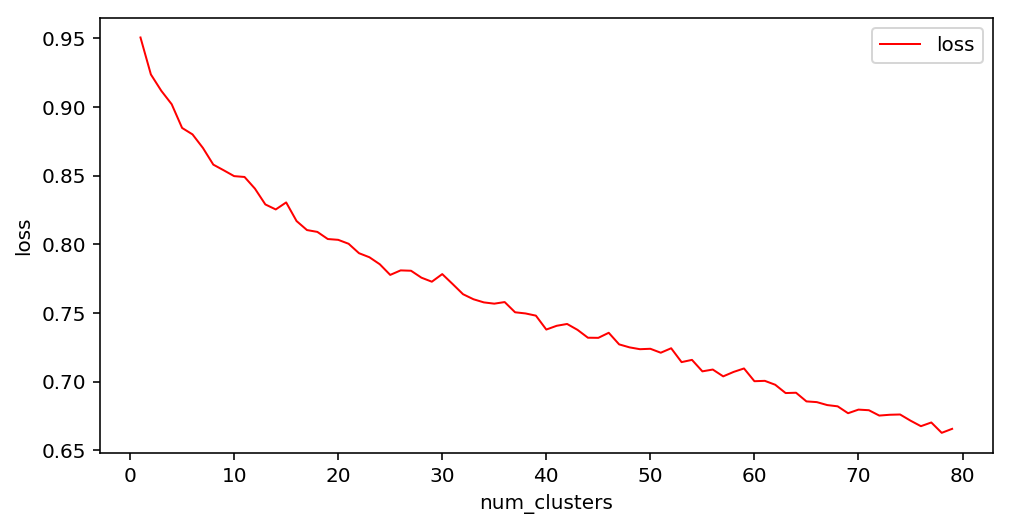

In [696]:
test(x, cauTexts)

In [686]:
x.shape

(824, 512)

In [681]:
vectorizer = TfidfVectorizer(max_df=0.5, 
                                     max_features=512, 
                                     stop_words=stopList,
                                     min_df=10,
                                     use_idf=True)
x = vectorizer.fit_transform(cauTexts)

In [697]:
result = train(x, cauTexts, num_clusters=5, showLable=True)
#result = train(c_sent2vec, cauTexts, num_clusters=4, showLable=True)

Top terms per cluster:
frozenset({'34', '03', '39', '32', '月', '75', '86', '59', '37', '拟', '85', '200', '150', '68', '52', '83', '06', '为', '13', '42', '因为', '00', '500', '中', '46', '28', '74', '27', '30', '58', '98', '%', '09', '02', '73', '84', '87', '56', '70', '69', '亿元', '2000', '77', '100', '45', '62', '33', '54', '71', '16', '新', '47', '已', '01', '99', '日', '53', '同比', '65', '88', '48', '晚间', '44', '57', '50', '90', '2017', '07', '67', '76', '41', '05', '40', '96', '35', '23', '94', '81', '约', '04', '300', '不', '2016', '5000', '93', '80', '29', '11', '55', '3000', '66', '31', '14', '19', '20', '因', '38', '将', '21', '2018', '15', '49', '10', '股', '72', '4000', '95', '79', '60', '82', '年', '26', '20142016', '08', '后', '24', '89', '2015', '92', '78', '25', '2014', '51', '63', '万元', '64', '1000', '91', '36', '元', '61', '97', '18', '22', '12', '43', '2019', '17'})
Cluster 1: 有限公司 公告 股权 项目 影响 表示 集团 经营 收购 子公司 股份
Cluster 2: 董事 执行 委员会 辞职 职务 担任 董事会 董事长 成员 秘书 独立
Cluster 3: 增长 亏损 上半年 万港元 集

## Visualizing Document Clusters

In [649]:
vectorizer = TfidfVectorizer(max_df=0.5, 
                                     max_features=512, 
                                     stop_words=stopList,
                                     min_df=10,
                                     use_idf=True)
x = vectorizer.fit_transform(cauTexts)

In [667]:
x.shape

(824, 512)

In [668]:
c_sent2vec.shape

(824, 512)

In [691]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(x)

In [692]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [693]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster_1', 
                 1: 'Cluster_2', 
                 2: 'Cluster_3'}

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


TypeError: text() missing 1 required positional argument: 's'

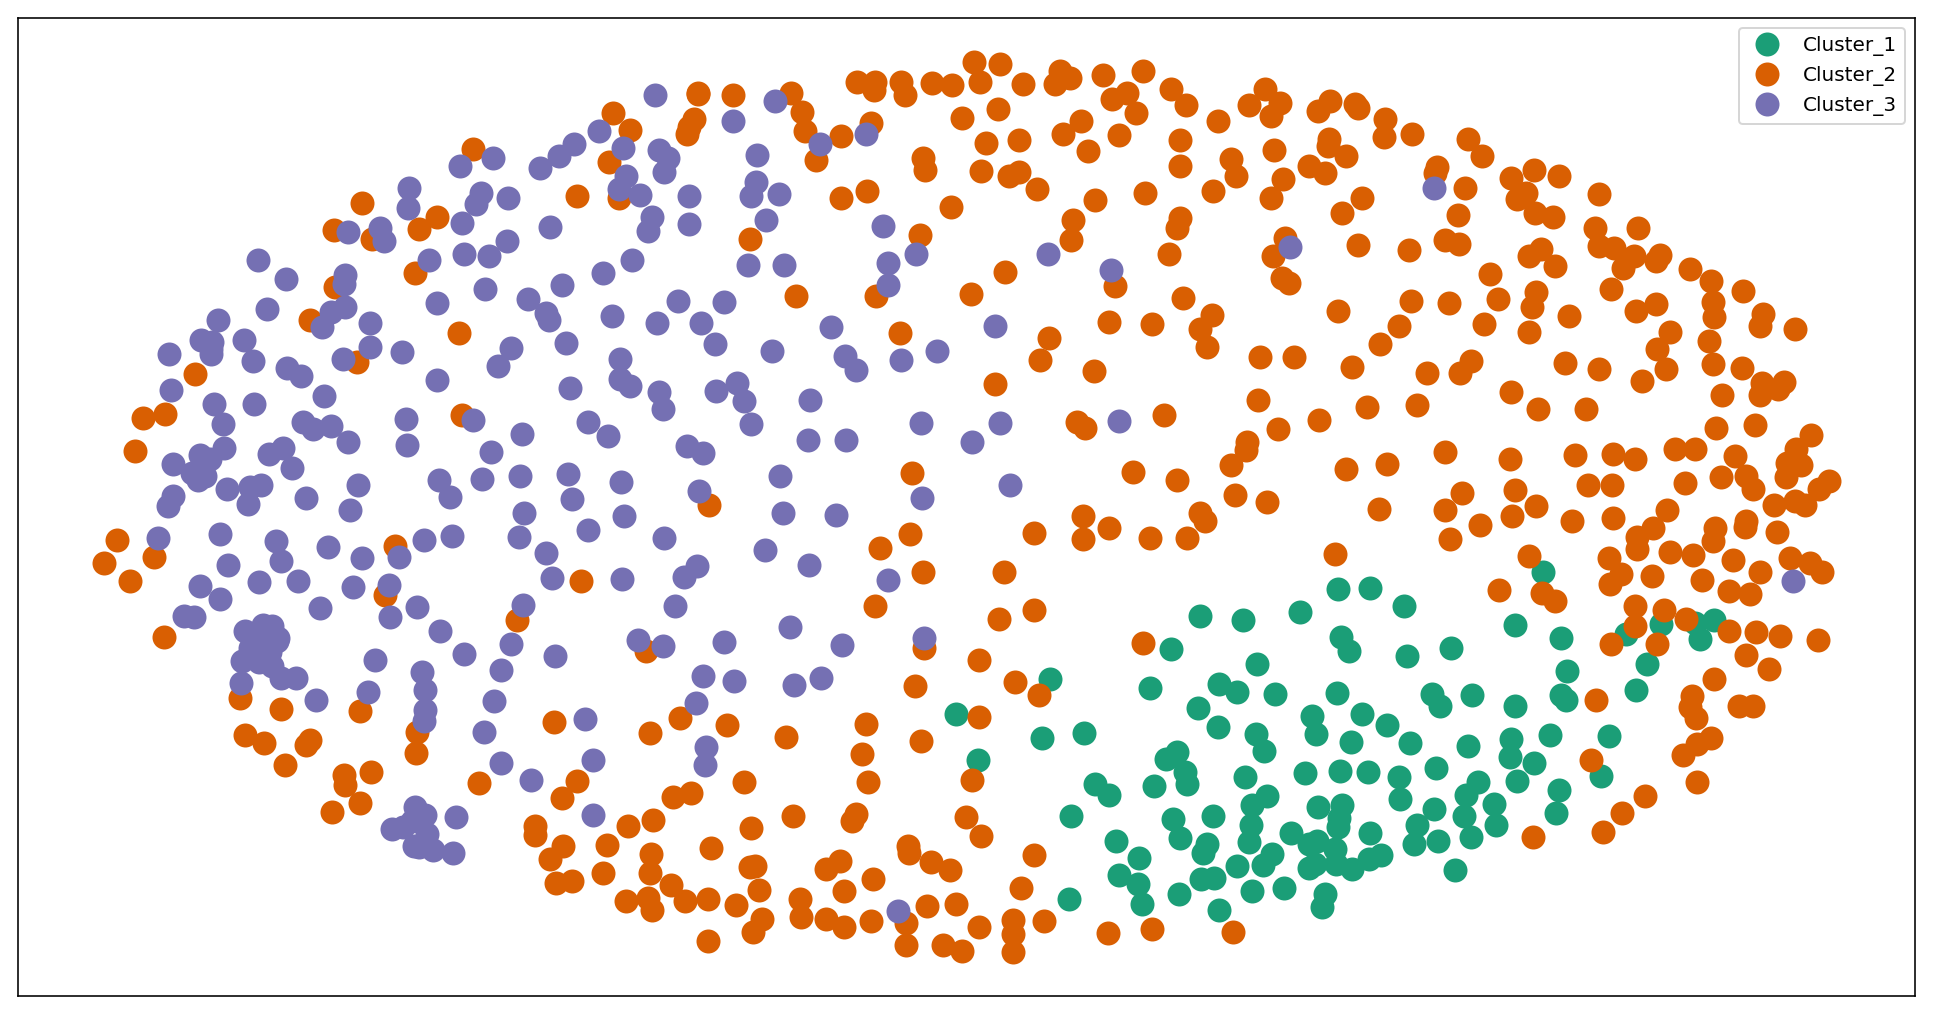

In [694]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import pandas as pd
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=result[-1])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

# LDA

In [546]:
from gensim import corpora, models, similarities 
from tqdm import tqdm

In [635]:
stopList = ['晚间', '拟', '元', '将', '亿元', '万元', '中', '约', '已', '不', '股', '后', '新', '同比', '因', '为', '因为', '年', '月', '日', '%' ,'00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2000', '2014', '20142016', '2015', '2016', '2017', '2018', '2019', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '300', '3000', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '500', '5000', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '150', '4000']

In [636]:
# remove stop words
#allWords = [[i for i in s if i not in stopList and not '.' in i and not i.isdigit()] for s in sentWords]
cauWords = [[i for i in s if i not in stopList and not '.' in i and not i.isdigit()] for s in c_sentWords]

In [549]:
#create a gensim dictionary from the texts
dictionary = corpora.Dictionary(cauWords)

# remove extremes
dictionary.filter_extremes(no_below=1, no_above=0.8)

# convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in cauWords]

In [569]:
%time lda = models.LdaModel(corpus, num_topics=1, id2word=dictionary, update_every=5, chunksize=5000, passes=100)

CPU times: user 1.95 s, sys: 37.7 ms, total: 1.99 s
Wall time: 2.04 s


In [637]:
def topic(document):
    """
    Generate document's topics
    """
    words = [[i for i in d if i not in stopList and not '.' in i and not i.isdigit()] for d in document]
    dictionary = corpora.Dictionary(words)
    dictionary.filter_extremes(no_below=1, no_above=0.5)
    corpus = [dictionary.doc2bow(s) for s in words]
    lda = models.LdaModel(corpus, 
                          num_topics=1, 
                          id2word=dictionary, 
                          update_every=5, 
                          chunksize=10000, 
                          passes=100)
    print(' '.join([i[0] for i in lda.show_topics(formatted=False, num_words=20)[0][-1]]))
    return lda

def prt(document, n):
    """
    Print result
    """
    cluster = [document[i] for i in range(len(document)) if result[1][i] == n]
    print("Cluster %d: " % (n+1), end='')
    c = topic(cluster)

In [630]:
for i in tqdm(range(3)):
    prt(sentWords, i)

  0%|          | 0/3 [00:00<?, ?it/s]

Cluster 1: 

 33%|███▎      | 1/3 [16:46<33:32, 1006.15s/it]

股份 亿元 公告 将 集团 股东 万元 有限公司 晚间 不 中 股 拟 已 控股 约 投资 增 发行 同比
Cluster 2: 

 67%|██████▋   | 2/3 [28:06<15:08, 908.29s/it] 

亿元 股份 公告 同比 晚间 上半年 股东 增长 万元 集团 将 实现 拟 净利润 不 元 发行 增 控股 已
Cluster 3: 

100%|██████████| 3/3 [54:51<00:00, 1117.33s/it]

股份 将 亿元 集团 万元 中 公告 约 有限公司 已 股东 发行 不 股 业务 后 中国 投资 新 同比
